In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

# Data Import

In [2]:
# Load data from csv
loandata = pd.read_csv('LoanData_orig.csv')


C:\Users\azegl\AppData\Local\Temp\ipykernel_9148\1236756246.py:2: DtypeWarning: Columns (12,34,38,80,82,83,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  loandata = pd.read_csv('LoanData_orig.csv')


In [3]:
# Check shape of df
dfOrig = pd.DataFrame(loandata)
dfOrig.shape

(373468, 112)

In [4]:
# Get more info about df
dfOrig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373468 entries, 0 to 373467
Columns: 112 entries, ReportAsOfEOD to ActiveLateLastPaymentCategory
dtypes: bool(3), float64(63), int64(11), object(35)
memory usage: 311.6+ MB


In [5]:
# Create new dataframe with values only relevant for loan default
df = dfOrig[['Age', 'AppliedAmount', 'DebtToIncome', 'AmountOfPreviousLoansBeforeLoan', 'Country', 'Education', 'EmploymentDurationCurrentEmployer', 'EmploymentStatus',
             'ExistingLiabilities', 'FreeCash', 'Gender', 'HomeOwnershipType', 'IncomeTotal', 'Interest', 'LiabilitiesTotal', 'LoanDuration', 'MaritalStatus',
             'MonthlyPayment', 'NewCreditCustomer', 'NoOfPreviousLoansBeforeLoan', 'NrOfDependants', 'NrOfScheduledPayments', 'OccupationArea', 
             'PreviousRepaymentsBeforeLoan', 'UseOfLoan', 'VerificationType', 'Status', 'City', 'WorkExperience', 'LanguageCode', 'EmploymentPosition', 'County']]
df.head(1)

,Age,AppliedAmount,DebtToIncome,AmountOfPreviousLoansBeforeLoan,Country,Education,EmploymentDurationCurrentEmployer,EmploymentStatus,ExistingLiabilities,FreeCash,...,OccupationArea,PreviousRepaymentsBeforeLoan,UseOfLoan,VerificationType,Status,City,WorkExperience,LanguageCode,EmploymentPosition,County
0,27,3189.0,0.0,3402.0,EE,3.0,UpTo5Years,-1.0,0,0.0,...,-1.0,1161.57,-1,4.0,Late,NaN,NaN,1,NaN,NaN


In [6]:
def find_missing_columns(df1, df2):

  missing_cols = set(df1.columns) - set(df2.columns)
  return df1[list(missing_cols)].sort_index(axis=1)


missing_df = find_missing_columns(dfOrig.copy(), df.copy())

if not missing_df.empty:
  print("Following columns are present in df1 but not in df2:")
  print(missing_df)
else:
  print("All columns in df2 are present in df1.")

Following columns are present in df1 but not in df2:
       ActiveLateCategory ActiveLateLastPaymentCategory  \
0                     NaN                           1-7   
1                   16-30                         61-90   
2                     1-7                         16-30   
3                    180+                          180+   
4                     NaN                           NaN   
...                   ...                           ...   
373463                NaN                           NaN   
373464                NaN                           NaN   
373465                NaN                           NaN   
373466                NaN                           NaN   
373467                NaN                           NaN   

        ActiveScheduleFirstPaymentReached  Amount  ApplicationSignedHour  \
0                                    True  3189.0                     12   
1                                    True  4146.0                     23   
2         

In [7]:
# Check how empty values per column
df.isnull().sum()

Age                                       0
AppliedAmount                             0
DebtToIncome                             50
AmountOfPreviousLoansBeforeLoan          13
Country                                   0
Education                                50
EmploymentDurationCurrentEmployer     10968
EmploymentStatus                        202
ExistingLiabilities                       0
FreeCash                                 50
Gender                                   45
HomeOwnershipType                      1657
IncomeTotal                               0
Interest                                  0
LiabilitiesTotal                          0
LoanDuration                              0
MaritalStatus                            50
MonthlyPayment                         6690
NewCreditCustomer                         0
NoOfPreviousLoansBeforeLoan              13
NrOfDependants                       337868
NrOfScheduledPayments                173355
OccupationArea                  

In [8]:
# Check values of column NewCreditCustomer
unique_values = df['NewCreditCustomer'].unique()
unique_values

array([False,  True])

# Data Preparation & Transformation

In [9]:
# Create mappings for data transformations

education_map = {
  -1.0: pd.NA,
  0.0: pd.NA,
  1.0: "Primary education",
  2.0: "Basic education",
  3.0: "Vocational education",
  4.0: "Secondary education",
  5.0: "Higher education"
}

employmentstatus_map = {
  -1.0	: pd.NA,
  0.0: pd.NA,
  1.0: "Unemployed",
  2.0: "Partially employed",
  3.0: "Fully employed",
  4.0: "Self-employed",
  5.0: "Entrepreneur",
  6.0: "Retiree"
}

occupationarea_map = {
  -1.0: pd.NA,
  0.0: pd.NA,
  1.0: "Other",
  2.0: "Mining",
  3.0: "Processing",
  4.0: "Energy",
  5.0: "Utilities",
  6.0: "Construction",
  7.0: "Retail and wholesale",
  8.0: "Transport and warehousing",
  9.0: "Hospitality and catering",
  10.0: "Info and telecom",
  11.0: "Finance and insurance",
  12.0: "Real-estate",
  13.0: "Research",
  14.0: "Administrative",
  15.0: "Civil services",
  16.0: "Education",
  17.0: "Healthcare and social help",
  18.0: "Art and entertainment",
  19.0: "Agriculture, forestry and fishing"
}



verificationtype_map = {
  0.0: "Not set",
  1.0: "Income unverified",
  2.0: "Income unverified, cross-referenced by phone",
  3.0: "Income verified",
  4.0: "Income and expenses verified",
}

languagecode_map = {
  1: "Estonian",
  2: "English",
  3: "Russian",
  4: "Finnish",
  5: "German",
  6: "Spanish",
  9: "Slovakian"
}

homeownershiptype_map = {
  -1.0: pd.NA,
  0.0: "Homeless",
  1.0: "Owner",
  2.0: "Living with parents",
  3.0: "Tenant, pre-furnished property",
  4.0: "Tenant, unfurnished property",
  5.0: "Council house",
  6.0: "Joint tenant",
  7.0: "Joint ownership",
  8.0: "Mortgage",
  9.0: "Owner with encumbrance",
  10.0: "Other"
}

maritalstatus_map = {
  -1.0: pd.NA,
  0.0: pd.NA,
  1.0: "Married",
  2.0: "Cohabitant",
  3.0: "Single",
  4.0: "Divorced",
  5.0: "Widow"
}

newcreditcustomer_map = {
  False: 0,
  True: 1
}

gender_map = {
  0.0: "Male",
  1.0: "Female",
  2.0: "Undefined"
}

default_map = {
  "Repaid": 0,
  "Late": 1
}

useofloan_map = {
  -1: pd.NA,
  0: "Loan consolidation",
  1: "Real estate",
  2: "Home improvement",
  3: "Business",
  4: "Education",
  5: "Travel",
  6: "Vehicle",
  7: "Other",
  8: "Health",
  101: "Working capital financing",
  102: "Purchase of machinery equipment",
  103: "Renovation of real estate",
  104: "Accounts receivable financing",
  105: "Acquisition of means of transport",
  106: "Construction finance",
  107: "Acquisition of stocks",
  108: "Acquisition of real estate",
  109: "Guaranteeing obligation",
  110: "Other business"
}

In [10]:
#Check values in df
df.loc[:,['Education', 'EmploymentStatus', 'OccupationArea', 'VerificationType', 'LanguageCode', 'HomeOwnershipType', 'MaritalStatus', 'Gender', 'NewCreditCustomer']].head()

,Education,EmploymentStatus,OccupationArea,VerificationType,LanguageCode,HomeOwnershipType,MaritalStatus,Gender,NewCreditCustomer
0,3.0,-1.0,-1.0,4.0,1,10.0,-1.0,1.0,False
1,5.0,-1.0,-1.0,4.0,4,1.0,-1.0,1.0,False
2,5.0,-1.0,-1.0,4.0,1,3.0,-1.0,0.0,False
3,4.0,6.0,1.0,4.0,1,1.0,2.0,1.0,False
4,3.0,-1.0,-1.0,4.0,4,3.0,-1.0,0.0,False


In [11]:
# Map the values using the defined mappings
df.loc[:, 'Education'] = df["Education"].map(education_map)
df.loc[:, 'EmploymentStatus'] = df["EmploymentStatus"].map(employmentstatus_map)
df.loc[:, 'OccupationArea'] = df["OccupationArea"].map(occupationarea_map)
df.loc[:, 'UseOfLoan'] = df["UseOfLoan"].map(useofloan_map)
df.loc[:, 'VerificationType'] = df["VerificationType"].map(verificationtype_map)
df.loc[:, 'LanguageCode'] = df["LanguageCode"].map(languagecode_map)
df.loc[:, 'HomeOwnershipType'] = df["HomeOwnershipType"].map(homeownershiptype_map)
df.loc[:, 'MaritalStatus'] = df["MaritalStatus"].map(maritalstatus_map)
df.loc[:, 'Gender'] = df["Gender"].map(gender_map)
#df.loc[:, 'NewCreditCustomer'] = df["NewCreditCustomer"].map(gender_map)

C:\Users\azegl\AppData\Local\Temp\ipykernel_9148\2907624269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Education'] = df["Education"].map(education_map)
C:\Users\azegl\AppData\Local\Temp\ipykernel_9148\2907624269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'EmploymentStatus'] = df["EmploymentStatus"].map(employmentstatus_map)
C:\Users\azegl\AppData\Local\Temp\ipykernel_9148\2907624269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [12]:
# Check values in df
df.loc[:,['Education', 'EmploymentStatus', 'OccupationArea', 'VerificationType', 'LanguageCode', 'HomeOwnershipType', 'MaritalStatus', 'Gender', 'NewCreditCustomer']].head()

,Education,EmploymentStatus,OccupationArea,VerificationType,LanguageCode,HomeOwnershipType,MaritalStatus,Gender,NewCreditCustomer
0,Vocational education,<NA>,<NA>,Income and expenses verified,Estonian,Other,<NA>,Female,False
1,Higher education,<NA>,<NA>,Income and expenses verified,Finnish,Owner,<NA>,Female,False
2,Higher education,<NA>,<NA>,Income and expenses verified,Estonian,"Tenant, pre-furnished property",<NA>,Male,False
3,Secondary education,Retiree,Other,Income and expenses verified,Estonian,Owner,Cohabitant,Female,False
4,Vocational education,<NA>,<NA>,Income and expenses verified,Finnish,"Tenant, pre-furnished property",<NA>,Male,False


In [13]:
# Check absolute & relative status counts 
print("Absolute Status counts ")
print(df['Status'].value_counts())
print(" ")
print("Relative Status counts: ",df.value_counts('Status', normalize=True))

Absolute Status counts 
Repaid     149177
Current    120874
Late       103417
Name: Status, dtype: int64
 
Relative Status counts:  Status
Repaid     0.399437
Current    0.323653
Late       0.276910
dtype: float64


In [14]:
# Drop all rows that have the Status 'Current'
df = df[df['Status'] != 'Current']
df.shape

(252594, 32)

In [15]:
# Create the 'Default' column based on the 'Status' column using the mapping defined earlier
df.loc[:, 'Default'] = df["Status"].map(default_map)
print("Absolute Default counts: ",df['Default'].value_counts())
print("Relative Default counts: ",df.value_counts('Default', normalize=True))

Absolute Default counts:  0    149177
1    103417
Name: Default, dtype: int64
Relative Default counts:  Default
0    0.59058
1    0.40942
dtype: float64


C:\Users\azegl\AppData\Local\Temp\ipykernel_9148\4083436941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Default'] = df["Status"].map(default_map)


array([[<AxesSubplot: title={'center': 'Age'}>]], dtype=object)

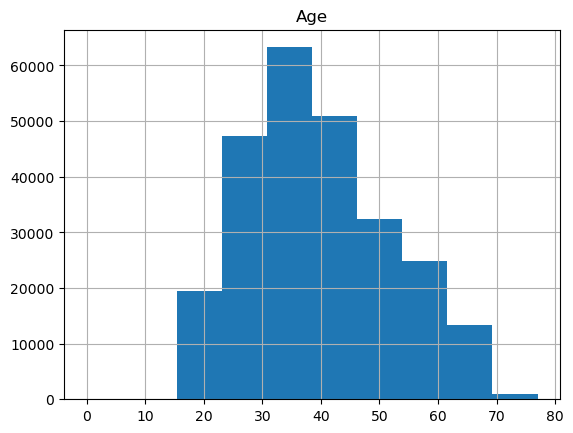

In [16]:
df.hist(column='Age')

In [17]:
# Create new column 'Age_Group' based on column 'Age' using bins

# Define the bin labels
bins = [18, 30, 40, 50, 60, 70]
labels = ['18-30', '31-40', '41-50', '51-60', '61-70']

# Create the new 'Age_Group' column using cut
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

#Sample of first 5 rows to check
df[['Age','Age_Group']].head()

C:\Users\azegl\AppData\Local\Temp\ipykernel_9148\2505352635.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)


,Age,Age_Group
0,27,18-30
1,35,31-40
2,23,18-30
3,53,51-60
7,40,31-40


In [18]:
# Check number of empty values per column
df.isnull().sum()

Age                                       0
AppliedAmount                             0
DebtToIncome                             50
AmountOfPreviousLoansBeforeLoan           8
Country                                   0
Education                              3879
EmploymentDurationCurrentEmployer      4451
EmploymentStatus                     216868
ExistingLiabilities                       0
FreeCash                                 50
Gender                                   45
HomeOwnershipType                      1660
IncomeTotal                               0
Interest                                  0
LiabilitiesTotal                          0
LoanDuration                              0
MaritalStatus                        216692
MonthlyPayment                         6680
NewCreditCustomer                         0
NoOfPreviousLoansBeforeLoan               8
NrOfDependants                       217606
NrOfScheduledPayments                173155
OccupationArea                  

In [19]:
# Check percentage of empty values per column

# Calculate the percentage of values being NaN for each column
rows = len(df)
missing = df.isnull().sum()
percentage_missing = missing / rows

# Put the data in a DataFrame and sort it
percentage_missing_df = pd.DataFrame({'Missing' : percentage_missing})
percentage_missing_df.sort_values('Missing', ascending = False, inplace = True)

# Print columns with percentage of missing values
percentage_missing_df.style.format("{:.1%}")

,Missing
County,100.0%
EmploymentPosition,100.0%
City,100.0%
NrOfDependants,86.1%
EmploymentStatus,85.9%
OccupationArea,85.8%
WorkExperience,85.8%
MaritalStatus,85.8%
UseOfLoan,85.8%
NrOfScheduledPayments,68.6%


In [20]:
# Check percentage of empty values per column

# Calculate the percentage of values being NaN for each column
rows = len(df)
missing = df.isnull().sum()
percentage_missing = missing / rows

# Put the data in a DataFrame and sort it
percentage_missing_df = pd.DataFrame({'Feature': missing, 'Missing' : percentage_missing})
percentage_missing_df.sort_values('Missing', ascending = False, inplace = True)

# Print columns with percentage of missing values
percentage_missing_df.style.format("{:.1%}")

,Feature,Missing
County,25259400.0%,100.0%
EmploymentPosition,25259400.0%,100.0%
City,25259400.0%,100.0%
NrOfDependants,21760600.0%,86.1%
EmploymentStatus,21686800.0%,85.9%
OccupationArea,21678700.0%,85.8%
WorkExperience,21670000.0%,85.8%
MaritalStatus,21669200.0%,85.8%
UseOfLoan,21663400.0%,85.8%
NrOfScheduledPayments,17315500.0%,68.6%


In [21]:
# Drop columns with certain percentage of empty values

df.drop(columns=['EmploymentStatus', 'MaritalStatus', 'NrOfDependants', 'NrOfScheduledPayments', 'OccupationArea', 'PreviousRepaymentsBeforeLoan', 'UseOfLoan',
                 'City', 'WorkExperience', 'EmploymentPosition', 'County', 'Status', 'Age'], inplace=True)
df.shape

C:\Users\azegl\AppData\Local\Temp\ipykernel_9148\1241124138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['EmploymentStatus', 'MaritalStatus', 'NrOfDependants', 'NrOfScheduledPayments', 'OccupationArea', 'PreviousRepaymentsBeforeLoan', 'UseOfLoan',


(252594, 21)

In [22]:
# For remaining instances drop all rows containing at least 1 empty value

df = df.dropna()
df.shape

(241909, 21)

In [23]:
# Check empty values per column
df.isnull().sum()

AppliedAmount                        0
DebtToIncome                         0
AmountOfPreviousLoansBeforeLoan      0
Country                              0
Education                            0
EmploymentDurationCurrentEmployer    0
ExistingLiabilities                  0
FreeCash                             0
Gender                               0
HomeOwnershipType                    0
IncomeTotal                          0
Interest                             0
LiabilitiesTotal                     0
LoanDuration                         0
MonthlyPayment                       0
NewCreditCustomer                    0
NoOfPreviousLoansBeforeLoan          0
VerificationType                     0
LanguageCode                         0
Default                              0
Age_Group                            0
dtype: int64

In [24]:
# Get info about data types, non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241909 entries, 0 to 373461
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   AppliedAmount                      241909 non-null  float64 
 1   DebtToIncome                       241909 non-null  float64 
 2   AmountOfPreviousLoansBeforeLoan    241909 non-null  float64 
 3   Country                            241909 non-null  object  
 4   Education                          241909 non-null  object  
 5   EmploymentDurationCurrentEmployer  241909 non-null  object  
 6   ExistingLiabilities                241909 non-null  int64   
 7   FreeCash                           241909 non-null  float64 
 8   Gender                             241909 non-null  object  
 9   HomeOwnershipType                  241909 non-null  object  
 10  IncomeTotal                        241909 non-null  float64 
 11  Interest                  

In [25]:
# Create two arrays containing only numeric or only categorical columns
categorical_values = ['Country', 'Education', 'EmploymentDurationCurrentEmployer', 'Gender', 'HomeOwnershipType', 'NewCreditCustomer',
                      'VerificationType', 'LanguageCode','Age_Group', 'Default']
numerical_values = ['AppliedAmount', 'DebtToIncome', 'AmountOfPreviousLoansBeforeLoan', 'ExistingLiabilities', 'FreeCash', 'IncomeTotal', 'Interest', 
                    'LiabilitiesTotal', 'LoanDuration', 'MonthlyPayment', 'NoOfPreviousLoansBeforeLoan']

In [26]:
# Get statistical info about df
df.describe()

,AppliedAmount,DebtToIncome,AmountOfPreviousLoansBeforeLoan,ExistingLiabilities,FreeCash,IncomeTotal,Interest,LiabilitiesTotal,LoanDuration,MonthlyPayment,NoOfPreviousLoansBeforeLoan,Default
count,241909.000000,241909.000000,241909.000000,241909.000000,241909.000000,2.419090e+05,241909.000000,2.419090e+05,241909.000000,241909.000000,241909.000000,241909.000000
mean,2683.501609,3.745569,3325.494243,2.554332,57.644131,1.984389e+03,30.611827,4.425071e+02,48.577250,107.817133,1.557445,0.419927
std,2206.381912,12.104399,5223.085653,2.849270,513.220383,9.940176e+03,21.384658,2.525355e+04,17.673087,102.602689,2.472138,0.493548
min,95.867500,0.000000,0.000000,0.000000,-76.930000,1.000000e-01,7.260000,0.000000e+00,1.000000,0.000000,0.000000,0.000000
25%,744.000000,0.000000,0.000000,1.000000,0.000000,1.000000e+03,19.600000,4.464000e+01,36.000000,36.150000,0.000000,0.000000
50%,2126.000000,0.000000,531.000000,2.000000,0.000000,1.500000e+03,22.350000,2.500000e+02,60.000000,92.800000,1.000000,0.000000
75%,4146.000000,0.000000,4668.000000,4.000000,0.000000,2.200000e+03,36.670000,5.210000e+02,60.000000,136.480000,2.000000,1.000000
max,14992.000000,75.610000,119983.000000,40.000000,158748.640000,1.012019e+06,264.310000,1.240000e+07,120.000000,2368.540000,31.000000,1.000000


In [27]:
#profile = ProfileReport(df)
#profile

In [28]:
# Check value counts for different columns
print(df['Gender'].value_counts())
print(df['Age_Group'].value_counts())
print(df['LanguageCode'].value_counts())
print(df['Education'].value_counts())
print(df['Country'].value_counts())
print(df['VerificationType'].value_counts())

Male         141149
Female        85589
Undefined     15171
Name: Gender, dtype: int64
31-40    74230
18-30    61917
41-50    54937
51-60    34477
61-70    16348
Name: Age_Group, dtype: int64
Finnish      93704
Estonian     91328
Spanish      28815
Russian      25522
English       2286
Slovakian      250
German           4
Name: LanguageCode, dtype: int64
Secondary education     75725
Vocational education    74121
Higher education        57492
Primary education       29119
Basic education          5452
Name: Education, dtype: int64
EE    117868
FI     94844
ES     28949
SK       248
Name: Country, dtype: int64
Income and expenses verified                    186401
Income unverified                                46758
Income verified                                   8604
Income unverified, cross-referenced by phone       146
Name: VerificationType, dtype: int64


In [29]:
print(len(df[(df['LanguageCode']=='Slovakian') & (df['Default']>0)]))
print(len(df[(df['LanguageCode']=='Slovakian') & (df['Default']<1)]))

print(len(df[(df['Country']=='SK') & (df['Default']>0)]))
print(len(df[(df['Country']=='SK') & (df['Default']<1)]))

4
246
4
244


In [30]:
# Calculate loan default rate 

defaulted_loans = len(df[(df['Default']==1) & (df['Gender']=='Female')])

default_rate = defaulted_loans / 85589 * 100
default_rate

39.089135286076484

In [31]:
# Calculate loan default rates for different columns

def calculate_default_rates_by_category(df, categories):

  default_rates = {}
  for col in categories:
    # Group data by the column and Default
    grouped_data = df.groupby(col)["Default"].mean().reset_index()

    # Rename column for clarity (optional)
    grouped_data.columns = [col, "Default Rate"]

    # Calculate default rate as a percentage
    grouped_data["Default Rate"] *= 100

    # Convert to dictionary for this column
    default_rates_by_col = grouped_data.set_index(col)["Default Rate"].to_dict()

    # Add results for this column to the main dictionary
    default_rates[col] = default_rates_by_col

  return default_rates


categories_of_interest = ["Gender", "LanguageCode", "Country", "Education", "Age_Group"]
default_rates_by_category = calculate_default_rates_by_category(df, categories_of_interest)
print(f"Default Rates by Category:")
for col, rates in default_rates_by_category.items():
  print(f"\t{col}: {rates}")


Default Rates by Category:
	Gender: {'Female': 39.089135286076484, 'Male': 41.13950506202666, 'Undefined': 66.31072440841078}
	LanguageCode: {'English': 43.48206474190726, 'Estonian': 31.657323055360898, 'Finnish': 46.86352770426022, 'German': 0.0, 'Russian': 38.739127027662406, 'Slovakian': 1.6, 'Spanish': 62.030192608016655}
	Country: {'EE': 33.131129738351376, 'ES': 62.09195481709213, 'FI': 46.97608704820547, 'SK': 1.6129032258064515}
	Education: {'Basic education': 30.429200293470288, 'Higher education': 37.68872190913519, 'Primary education': 50.94955183900546, 'Secondary education': 39.7504126774513, 'Vocational education': 44.95352194384857}
	Age_Group: {'18-30': 38.52415330200107, '31-40': 40.65337464636939, '41-50': 42.89822888035386, '51-60': 45.76964353046959, '61-70': 50.20185955468559}


In [32]:
# Check values of column
df['NewCreditCustomer'].head()

0    False
1    False
2    False
3    False
7    False
Name: NewCreditCustomer, dtype: bool

In [33]:
# Change column 'NewCreditCustomer' datatype to int
df['NewCreditCustomer'] = df['NewCreditCustomer'].astype('int64')

C:\Users\azegl\AppData\Local\Temp\ipykernel_9148\3782994880.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NewCreditCustomer'] = df['NewCreditCustomer'].astype('int64')


In [34]:
# Check values of column
df['NewCreditCustomer'].head()

0    0
1    0
2    0
3    0
7    0
Name: NewCreditCustomer, dtype: int64

In [35]:
df.shape

(241909, 21)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241909 entries, 0 to 373461
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   AppliedAmount                      241909 non-null  float64 
 1   DebtToIncome                       241909 non-null  float64 
 2   AmountOfPreviousLoansBeforeLoan    241909 non-null  float64 
 3   Country                            241909 non-null  object  
 4   Education                          241909 non-null  object  
 5   EmploymentDurationCurrentEmployer  241909 non-null  object  
 6   ExistingLiabilities                241909 non-null  int64   
 7   FreeCash                           241909 non-null  float64 
 8   Gender                             241909 non-null  object  
 9   HomeOwnershipType                  241909 non-null  object  
 10  IncomeTotal                        241909 non-null  float64 
 11  Interest                  

In [37]:
# Save df to csv
df.to_csv('LoanData_prepared.csv', index=False)  